### Dependencies
This assumes you have `pandas`, `numpy`, `jupyterlab` and `pandas-ta` available in your system or virtual environment. 
You also need `ta-lib`, on macOS you can get it with `brew install ta-lib`

### Configuration
Create a file called `.env` with:
```env
EXCHG_API_KEY=d019f019ca0918c0ac80
EXCHG_SECRET=ba19ca9310de910
```

In [ ]:
import sys
# install dependencies
!{sys.executable} -m pip install -q hyperopt matplotlib ipywidgets
!{sys.executable} -m pip install --no-deps git+https://github.com/revmischa/pyjuque@patch-1

You should consider upgrading via the '/Users/cyber/Library/Caches/pypoetry/virtualenvs/trader-cictOTB5-py3.9/bin/python -m pip install --upgrade pip' command.
  Cloning https://github.com/revmischa/pyjuque (to revision patch-1) to /private/var/folders/kd/1xqhjdy16c31k9ffswc8wbm40000gn/T/pip-req-build-d2irbiku
  Running command git clone -q https://github.com/revmischa/pyjuque /private/var/folders/kd/1xqhjdy16c31k9ffswc8wbm40000gn/T/pip-req-build-d2irbiku
  Running command git checkout -b patch-1 --track origin/patch-1
  Switched to a new branch 'patch-1'
  Branch 'patch-1' set up to track remote branch 'patch-1' from 'origin'.
  Resolved https://github.com/revmischa/pyjuque to commit 22c1641a62f34917bd917e64c5b4aeca4722a7ce
You should consider upgrading via the '/Users/cyber/Library/Caches/pypoetry/virtualenvs/trader-cictOTB5-py3.9/bin/python -m pip install --upgrade pip' command.


In [117]:
import time
import os
from pprint import pprint
import logging
import cProfile
from typing import Dict
import datetime
import math
from IPython.display import HTML
from copy import deepcopy
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import pandas_ta as ta
from hyperopt import hp, tpe, fmin, STATUS_OK,STATUS_FAIL, Trials
import matplotlib.pyplot as plt

from pyjuque.Bot import defineBot
from pyjuque.Plotting import PlotData, GetPlotData
from pyjuque.Exchanges.CcxtExchange import CcxtExchange
from pyjuque.Engine.BacktesterSundayTheQuant import Backtester
from pyjuque.Strategies import StrategyTemplate

# how many cores we have
workers = os.cpu_count()
os.environ['NUMEXPR_MAX_THREADS'] = str(workers)

%matplotlib inline
PROFILING = False

# shut up
tpe_logger = logging.getLogger('hyperopt.tpe')
tpe_logger.setLevel(logging.WARNING)

# connect to your exchange
exchange = CcxtExchange("ftx")

In [136]:
timeframe = '1m'  # 1 minute timeframe
starting_balance = 100.  # of currency we're trading

# configure your exchange here via .env file
load_dotenv()
api_key = os.environ["EXCHG_API_KEY"]
secret = os.environ["EXCHG_SECRET"]
exchange_config = {
    "exchange": {
        "name": "ftx",
        "params": {
            "api_key": api_key,
            "secret": secret,
        },
    },
}

def gen_config(
    StratClass,
    params: Dict[str, float],
    test_run=True,
    signal_distance: float = 0.3,
    take_profit: float = 4,
    stop_loss_value: float = 6,
    initial_entry_allocation: float = 33,
) -> dict:
    return {
        "name": "simulator",
        "test_run": test_run,
        **exchange_config,
        "symbols": [
            "ETH/USD",
        ],
        "starting_balance": starting_balance,
        "strategy": {"class": StratClass, "params": params},
        "timeframe": timeframe,
        "entry_settings": {
            "initial_entry_allocation": initial_entry_allocation,
            "signal_distance": signal_distance,  # pct under buy signal to place order
            "leverage": 1,
        },
        "exit_settings": {
            "take_profit": take_profit,
            "stop_loss_value": stop_loss_value,
            "exit_on_signal": True,
            "sell_on_end": True,
        },
    }


In [137]:
# utilities
symbol_df_cache: Dict[str, pd.DataFrame] = {}

# how far units of timeframe (min) to test back in time
backtest_times = 60 * 24

def backtest(bot_config: dict) -> Backtester:
    bt = Backtester(bot_config)
    results = {}
    for symbol in bot_config["symbols"]:
        # fetch historical exchange data (OHLCV) for symbol
        # backtesting will be performed on this dataset
        if not symbol in symbol_df_cache:
            symbol_df_cache[symbol] = exchange.getOHLCV(symbol, bot_config['timeframe'], backtest_times)
        df = symbol_df_cache[symbol]

        # backtest
        bt.backtest(df)
        results[symbol] = dict(results=bt.return_results(), entries=bt.entries, exits=bt.exits, df=df)
        
    return results

def plot_backtest_results(title, df, entries, exits):
    return PlotData(df, 
        plot_indicators=[
            dict(name = 'slow_ma', title = 'Slow HMA'),
            dict(name = 'fast_ma', title = 'Fast HMA'),
        ],
        signals=[
            dict(name = 'Buy', points = entries), 
            dict(name = 'Sell', points = exits),
        ], 
        add_volume=False,
        plot_title=title,
    )

In [138]:
# strategy to run
class EMACross(StrategyTemplate):
    """Bollinger Bands x RSI"""

    minimum_period = 100

    def __init__(self, fast_ma_len=10, slow_ma_len=50):
        self.fast_ma_len = fast_ma_len
        self.slow_ma_len = slow_ma_len
        # the minimum number of candles needed to compute our indicators
        self.minimum_period = max(100, slow_ma_len)

    # the bot will call this function with the latest data from the exchange
    # passed through df; this function computes all the indicators needed
    # for the signal
    def setUp(self, df):
        df["slow_ma"] = ta.ema(df["close"], self.slow_ma_len)
        df["fast_ma"] = ta.ema(df["close"], self.fast_ma_len)
        self.dataframe = df

    # the bot will call this function with the latest data and if this
    # returns true, our bot will place an order
    def checkLongSignal(self, i=None):
        """ """
        df = self.dataframe
        if i == None:
            i = len(df) - 1
        if i < 1:
            return False
        if (
            df["low"][i - 1] < df["slow_ma"][i - 1]
            and df["low"][i] > df["slow_ma"][i]
            and df["low"][i] > df["fast_ma"][i]
            and df["fast_ma"][i] > df["slow_ma"][i]
        ):
            return True
        return False

    def checkShortSignal(self, i=None):
        df = self.dataframe
        if i == None:
            i = len(df) - 1
        if i < 1:
            return False
        if (
            (
                df["low"][i - 1] > df["slow_ma"][i - 1]
                or df["fast_ma"][i - 1] > df["slow_ma"][i - 1]
            )
            and df["close"][i] < df["slow_ma"][i]
            and df["close"][i] < df["fast_ma"][i]
            and df["fast_ma"][i] < df["slow_ma"][i]
        ):
            return True
        return False

In [139]:
def calc_strat_loss(backtest_res) -> dict:
    """Given backtest results, calculate loss.
    
    Loss is a measure of how badly we're doing.
    """
    score = 0
    
    for symbol, symbol_res in backtest_res.items():
        symbol_bt_res = symbol_res['results']
        profit_realised = symbol_bt_res['profit_realised']
        profit_after_fees = symbol_bt_res['profit_after_fees']
        winrate = symbol_bt_res['winrate']

        if profit_after_fees < 0:
            # lost money.
            # bad.
            score -= profit_after_fees + 1

        if profit_after_fees == 0.0:
            # well it's not great but not terrible...
            pass

        # how well we're doing (positive)
        score += profit_after_fees# + winrate/100
        
    if score < 0:
        # not doing so good
        #print("score is bad", -1*score)
        return -1 * score

    # return loss; lower number is better
    #print("score=",score,math.pow(0.9, score))
    return math.pow(0.3, score)

def params_to_bot_config(p):
    params = {**p}
    # strat params
    fast_ma_len = p.pop('fast_ma_len')
    slow_ma_len = p.pop('slow_ma_len')
    bot_config = gen_config(
        StratClass=EMACross, 
        params=dict(fast_ma_len=fast_ma_len, slow_ma_len=slow_ma_len),
        **p
    )
    return bot_config

ITERATION = 0
def run_test(params):
    bot_config = params_to_bot_config(params)
    
    global ITERATION
    ITERATION += 1

    try:
        backtest_res = backtest(bot_config)
    except Exception as ex:
        if 'Not enough data' in str(ex) or 'TA_BAD_PARAM' in str(ex):
            #print("Failed with", bot_config, ex)
            return dict(status=STATUS_FAIL, loss=1, iteration=ITERATION)
        raise ex

    loss = calc_strat_loss(backtest_res)
    return dict(
        iteration=ITERATION,
        loss=loss,
        status=STATUS_OK,
        backtest_res=backtest_res,
    )

def opt_ema_strat(max_evals: int=10) -> Dict[str, float]:
    """Optimize EMA parameters"""
    space = {
        'fast_ma_len': hp.uniform('fast_ma_len', 3, 10),
        'slow_ma_len': hp.uniform('slow_ma_len', 5, 40),
        
        # number between 0 and 100 - 1% means that when we get a buy signal, 
        # we place buy order 1% below current price. if 0, we place a market 
        # order immediately upon receiving signal
        'signal_distance': hp.uniform('signal_distance', 0, 5),
        
        # take profit value between 0 and infinity, 3% means we place our sell 
        # orders 3% above the prices that our buy orders filled at
        'take_profit': hp.uniform('take_profit', 0.5, 30),
        
        # stop loss value in percent - 10% means stop loss at 10% below our 
        # buy order's filled price
        'stop_loss_value': hp.uniform('stop_loss_value', 2, 40),
        
        # between 0 and 100, the % of the starting_balance to put in an order
        'initial_entry_allocation': hp.choice('initial_entry_allocation', range(10, 20)),
    }
    
    tpe_trials = Trials()
    
    if PROFILING:
        pr = cProfile.Profile()
        pr.enable()
        
    # run optimizer
    global ITERATION
    ITERATION = 0
    best = fmin(fn = run_test,
                space = space,
                algo = tpe.suggest, 
                trials = tpe_trials,
                verbose = False,
                show_progressbar = False,
                max_evals = max_evals)
    
    if PROFILING:
        pr.disable()
        pr.dump_stats('profile')
    
    return (best, tpe_trials)

In [159]:
# run hyperopt
best, trials = opt_ema_strat(max_evals=3000)

print("Best:")
pprint(best)
best_config = params_to_bot_config(best)
backtest_res = backtest(best_config)
trial_results = trials.results

Best:
{'fast_ma_len': 9.259706706310398,
 'initial_entry_allocation': 9,
 'signal_distance': 4.167596696357992,
 'slow_ma_len': 6.249223446558828,
 'stop_loss_value': 31.69626875443707,
 'take_profit': 3.9788089754577722}


In [169]:
alloc = best_config['entry_settings']['initial_entry_allocation']
entry_exit_marker_size = 15
def fix_series_ts(initial_entry_allocation: float, series:list[tuple]):
    ret = []
    for e in series:
        n = [*e]
        n[0] = pd.to_datetime(n[0] * 10e5)
        n[2] = entry_exit_marker_size
        ret.append(n)
    return ret

# formatting and massaging results
for symbol, symbol_res in backtest_res.items():
    symbol_bt_res = symbol_res['results']
    profit = symbol_bt_res['profit_after_fees']
    initial = symbol_bt_res['balance_initial']
    bal = symbol_bt_res['balance_plus_profits']
    print(f"{symbol}: Initial {initial}, profit: {profit:0.3}, return %{(bal/float(initial)*100):.6}")
    #pprint(symbol_bt_res)
    df = symbol_res['df']
    sym_results[symbol] = df
    bt_res = [t.get('backtest_res', {}).get(symbol, {}) for t in trial_results]
            
    # trials w/ results
    btdf = pd.DataFrame({
        'loss': [min(x.get('loss',1), 1) for x in trial_results], 
        'iteration': [x['iteration'] for x in trial_results],
        'winrate': [r['results']['winrate'] if 'results' in r else 0 for r in bt_res],
        'profit': [max(0, profit / (r['results']['profit'] or 0.001)) if 'results' in r else 0 for r in bt_res],
    })

    # visualize backtesting
    # date and time columns are broken
    df2 = df.drop(columns=['date'])
    df2['time'] = pd.to_datetime(df['time'] * 10e5)
    fig = plot_backtest_results(symbol, df2, fix_series_ts(alloc, symbol_res['entries']), fix_series_ts(alloc, symbol_res['exits']))
fig

ETH/USD: Initial 100.0, profit: 0.975, return %100.975


FigureWidget({
    'data': [{'close': array([3312.6, 3311.3, 3313.2, ..., 3407.6, 3407.4, 3407.4]),
          …

In [ ]:
btdf['l'] = btdf['loss']
btdf.plot.scatter('iteration', y=['loss'], logy=True)

<AxesSubplot:xlabel='time'>

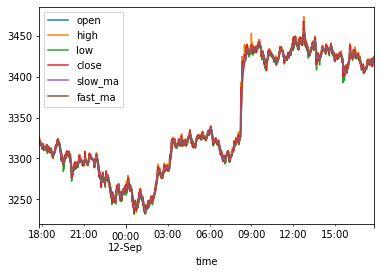

In [37]:
df2.drop(columns=['volume']).plot('time')

In [82]:
df2

,time,open,high,low,close,volume,slow_ma,fast_ma
0,2021-09-10 15:16:00,3242.5,3250.6,3241.2,3250.6,4.782509e+05,NaN,NaN
1,2021-09-10 15:17:00,3250.6,3252.3,3244.7,3245.2,1.554127e+06,NaN,NaN
2,2021-09-10 15:18:00,3245.2,3249.6,3241.2,3249.5,5.728494e+05,NaN,NaN
3,2021-09-10 15:19:00,3249.5,3255.5,3248.6,3254.1,5.007561e+05,NaN,3249.850000
4,2021-09-10 15:20:00,3254.1,3255.4,3242.1,3245.6,7.165826e+05,NaN,3248.150000
...,...,...,...,...,...,...,...,...
2875,2021-09-12 15:11:00,3426.7,3427.3,3423.6,3424.3,2.810520e+05,3425.037855,3424.527104
2876,2021-09-12 15:12:00,3424.3,3424.3,3421.9,3422.6,1.653003e+05,3424.733124,3423.756262
2877,2021-09-12 15:13:00,3422.6,3423.9,3422.4,3422.4,2.763484e+05,3424.441483,3423.213757
2878,2021-09-12 15:14:00,3422.4,3423.8,3422.4,3423.7,1.441225e+05,3424.348798,3423.408254


In [135]:
seq = np.linspace(0.001, 3, 2000)

<AxesSubplot:>

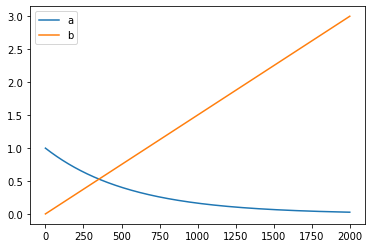

In [140]:
pd.DataFrame({'a': np.array([math.pow(0.3, x) for x in seq]),
            'b': np.array(seq)},
            ).plot()


In [130]:
math.pow(0.9, 0)

1.0